In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 16.0MB/s 


In [ ]:
downloaded = drive.CreateFile({'id':'1dDnroGFtb8V6-zSK4y46dK06zZXOY2fk'}) 
downloaded.GetContentFile('gun200.zip')

In [ ]:
import cv2, numpy as np, glob, os,shutil, keras, matplotlib.pyplot as plt,tensorflow as tf,matplotlib.mlab as mplt, sys
from matplotlib import style
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Convolution2D, MaxPooling2D, Dropout,ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split as tt
import scipy.io.wavfile
from math import sqrt
import librosa
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,f1_score,average_precision_score,confusion_matrix
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler as sd
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA


Using TensorFlow backend.


In [ ]:
!unzip 'gun200.zip'

Archive:  gun200.zip
   creating: gun200/
   creating: gun200/gunaud/
   creating: gun200/gunaud/0/
  inflating: gun200/gunaud/0/0.mp3   
  inflating: gun200/gunaud/0/2.mp3   
  inflating: gun200/gunaud/0/3.mp3   
  inflating: gun200/gunaud/0/4.mp3   
  inflating: gun200/gunaud/0/5.mp3   
   creating: gun200/gunaud/1/
  inflating: gun200/gunaud/1/0.mp3   
  inflating: gun200/gunaud/1/1.mp3   
  inflating: gun200/gunaud/1/2.mp3   
  inflating: gun200/gunaud/1/3.mp3   
  inflating: gun200/gunaud/1/4.mp3   
  inflating: gun200/gunaud/1/5.mp3   
   creating: gun200/gunaud/2/
  inflating: gun200/gunaud/2/0.mp3   
  inflating: gun200/gunaud/2/1.mp3   
  inflating: gun200/gunaud/2/2.mp3   
  inflating: gun200/gunaud/2/3.mp3   
  inflating: gun200/gunaud/2/5.mp3   
  inflating: gun200/gunaud/2/6.mp3   
  inflating: gun200/gunaud/2/7.mp3   
  inflating: gun200/gunaud/2/8.mp3   
  inflating: gun200/gunaud/2/9.mp3   
  inflating: gun200/gunaud/2/10.mp3  
  inflating: gun200/gunaud/2/11.mp3  
  in

In [ ]:
gun=[]
for i in range(91):
  try:
    if(i<51):
      shots=os.listdir('gun200/gunaud/'+str(i)+"/")
      for shot in shots:
        gun.append(librosa.load('gun200/gunaud/'+str(i)+"/"+shot))
    else:
      shots=os.listdir('gun200/gunaud/'+str(i)+"./")
      for shot in shots:
        gun.append(librosa.load('gun200/gunaud/'+str(i)+"./"+shot))
    
  except:
    print(i)
    
rifle=[]
for i in range(101):
  try:
    if(i<51):
      shots=os.listdir('gun200/rifleaud/'+str(i)+"/")
      for shot in shots:
        rifle.append(librosa.load('gun200/rifleaud/'+str(i)+"/"+shot))
    else:
      shots=os.listdir('gun200/rifleaud/'+str(i)+"./")
      for shot in shots:
        rifle.append(librosa.load('gun200/rifleaud/'+str(i)+"./"+shot))
  except:
    print(i)   

17
20
40
51
75
80
82
83
88
89
16
27
37
45
47
49
50
67
72
83
86
95


In [ ]:
gun_arr=[]
label=[]#for handgun l is 0
gl1=len(gun)
for i in range(gl1):
  if(gun[i][0].shape[0]==22200):
    fx=np.concatenate((np.array([-1.0]*150),gun[i][0],np.array([-1.0]*150)),axis=0)
    gun_arr.append(fx)
  elif(gun[i][0].shape[0]==21624):
    fx=np.concatenate((np.array([-1.0]*438),gun[i][0],np.array([-1.0]*438)),axis=0)
    gun_arr.append(fx)
        
  label.append(0)
rifle_arr=[]
rl1 = len(rifle)
for i in range(rl1):  
  if(rifle[i][0].shape[0]==22200):
    fx=np.concatenate((np.array([-1.0]*150),rifle[i][0],np.array([-1.0]*150)),axis=0)
    rifle_arr.append(fx)
  elif(rifle[i][0].shape[0]==21624):
    fx=np.concatenate((np.array([-1.0]*438),rifle[i][0],np.array([-1.0]*438)),axis=0)
    rifle_arr.append(fx)
        
  label.append(1)

In [ ]:
from IPython.display import Audio

In [ ]:
# got the gun and rifle
audio = gun_arr[0]

In [ ]:
Audio(audio,rate=22500)

In [ ]:
#librosa.feature.chroma_stft(audio,sr=22500),librosa.feature.chroma_cqt(audio,sr=22500),
def feautre_vc(audio):
  return np.concatenate((librosa.feature.chroma_cens(audio,sr=22500),
               librosa.feature.mfcc(audio,sr=22500,n_mfcc=44),librosa.feature.rms(audio), librosa.feature.rmse(audio), librosa.feature.spectral_centroid(audio,sr=22500),librosa.feature.melspectrogram(y=audio,sr=22500),
               librosa.feature.spectral_bandwidth(audio,sr=22500),librosa.feature.spectral_contrast(audio,sr=22500),librosa.feature.spectral_flatness(audio),librosa.feature.spectral_rolloff(audio,sr=22500),
               librosa.feature.poly_features(audio,sr=22500),librosa.feature.tonnetz(audio,sr=22500),librosa.feature.zero_crossing_rate(audio)),axis=0)

In [ ]:
def take_pca(train,test):
  
  # capture shape
  ts=test.shape
  tr=train.shape
  
  # reshape
  test= np.reshape(test,(len(test),-1))
  train=np.reshape(train,(len(train),-1))
  
  # take pca
  
  pca=PCA()
  pca.fit(train)
  train_pca=pca.transform(train)
  test_pca=pca.transform(test)
  
  print("shape before, train ",tr, "test",ts,"after pca train ",train_pca.shape,"test", test_pca)
  
  return train_pca,test_pca

  
  

In [ ]:
def 

In [ ]:
def normalize(train,test):
  ts=test.shape
  tr=train.shape
  
  test= np.reshape(test,(len(test),-1))
  train=np.reshape(train,(len(train),-1))
  
  s = sd()
  s.fit(train)
  train = s.transform(train)
  test = s.transform(test)
  
  test= np.reshape(test,ts)
  train=np.reshape(train,tr)
  
  return train, test

In [ ]:
#hop_length = 512

gun_arr_l=[]
label=[]#for handgun l is 0
for i in range(gl1):
  mfccg = feautre_vc(gun_arr[i])
  gun_arr_l.append(mfccg)
  label.append(0)

rifle_arr_l=[]
for i in range(rl1):
  mfccr = feautre_vc(rifle_arr[i])
  rifle_arr_l.append(mfccr)
  label.append(1)

In [ ]:
train_mfcc=np.array(gun_arr_l+rifle_arr_l)
#train_dmfcc=np.array(gd+rd)
label=np.array(label)
print(train_mfcc.shape)
#print(train_dmfcc.shape)
print(label.shape)


(1339, 206, 44)
(1339,)


In [ ]:
train_mfcc=np.reshape(train_mfcc,(-1,train_mfcc.shape[1],44,1))

In [ ]:
n=5
cv=StratifiedKFold(n_splits=n,shuffle=True)

In [ ]:
roctemp2=[]
f1s1=[]
aps1=[]
accs1=[]
aucs1=[]
X=train_mfcc
y=label
count=0
for train1, test1 in cv.split(X,y):
  train,val=X[train1], X[test1]
  ytrain = keras.utils.to_categorical(y[train1])
  yval= keras.utils.to_categorical(y[test1])
  
  #train,val=normalize(train,val)
  epoch = 100
  model = Sequential()
  model.add(Convolution2D(32, (2,2), input_shape=(train_mfcc.shape[1],44,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

  model.add(Convolution2D(64, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))



  model.add(Convolution2D(32, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Convolution2D(64, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Convolution2D(32, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Convolution2D(64, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))




  model.add(Convolution2D(32, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

  model.add(Convolution2D(64, 2, activation='relu',padding='same'))
  #model.add(ZeroPadding2D((1, 1)))
  model.add(MaxPooling2D(pool_size=2,padding='same'))
  #model.add(Dropout(0.3))


  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.8))
  model.add(Dense(2))
  model.add(Activation('softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  filepath="k1"+str(count)+".hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint]

  history=model.fit(train,ytrain, epochs=epoch,batch_size=None, verbose=1, validation_data=(val,yval) ,validation_split=None,callbacks=callbacks_list,  shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
  #model.save(dictm.get(mo)+"sound.h5")


  model = Sequential()
  model.add(Convolution2D(32, (2,2), input_shape=(train_mfcc.shape[1],44,1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

  model.add(Convolution2D(64, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))



  model.add(Convolution2D(32, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Convolution2D(64, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
  model.add(Convolution2D(32, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Convolution2D(64, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))




  model.add(Convolution2D(32, (2,2), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

  model.add(Convolution2D(64, 2, activation='relu',padding='same'))
  #model.add(ZeroPadding2D((1, 1)))
  model.add(MaxPooling2D(pool_size=2,padding='same'))
  #model.add(Dropout(0.3))


  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.8))
  model.add(Dense(2))
  model.add(Activation('softmax'))
  model.load_weights("k1"+str(count)+".hdf5")
  model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

  score=model.evaluate(val,yval)
  print(" accuracy", score[1]*100,"%")
  accs1.append(score[1])

  #print(dictm.get(mo)," : ",score[1]*100)
  probs=model.predict_proba(val)
  ys=np.argmax(yval, axis=1)
  auc = roc_auc_score(ys, probs[:,1])
  aucs1.append(auc)
  #yval2=keras.utils.to_categorical(yval)
  fpr, tpr, thresholds = roc_curve(ys, probs[:,1])
  # plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='--')
  # plt.plot(fpr, tpr, marker='.')
  # plt.show()
  f1 = f1_score(ys, model.predict_classes(val))
  f1s1.append(f1)
  ap = average_precision_score(ys, probs[:,1])
  aps1.append(ap)
  roctemp2.append([fpr, tpr, thresholds])
  print("auc, f1, ap " ,auc, f1, ap)
  count+=1
  # conf_mat=confusion_matrix(y, model.predict_classes(valf))
  # print(conf_mat)
  # precision, recall, thresholds = precision_recall_curve(y, probs[:,1])
  # roctemp2.append([precision, recall, thresholds])
  # plt.plot([1.0, 0.0], [0.0, 1.0], linestyle='--')
  # plt.plot(recall, precision, marker='.')
  # plt.show()


Train on 1070 samples, validate on 269 samples
Epoch 1/100
1070/1070 [==============================] - 9s 9ms/step - loss: 1.4919 - acc: 0.5150 - val_loss: 0.6867 - val_acc: 0.5613

Epoch 00001: val_acc improved from -inf to 0.56134, saving model to k10.hdf5
Epoch 2/100
1070/1070 [==============================] - 1s 982us/step - loss: 0.6992 - acc: 0.5327 - val_loss: 0.6983 - val_acc: 0.4944

Epoch 00002: val_acc did not improve from 0.56134
Epoch 3/100
1070/1070 [==============================] - 1s 903us/step - loss: 0.6898 - acc: 0.5477 - val_loss: 0.6840 - val_acc: 0.5316

Epoch 00003: val_acc did not improve from 0.56134
Epoch 4/100
1070/1070 [==============================] - 1s 918us/step - loss: 0.6939 - acc: 0.5393 - val_loss: 0.6851 - val_acc: 0.5093

Epoch 00004: val_acc did not improve from 0.56134
Epoch 5/100
1070/1070 [==============================] - 1s 900us/step - loss: 0.7123 - acc: 0.5187 - val_loss: 0.6839 - val_acc: 0.5874

Epoch 00005: val_acc improved from 0.5

In [ ]:
print(np.mean(f1s1))
print(np.mean(aps1))
print(np.mean(accs1))
print(np.mean(aucs1))

0.9497047877163473
0.9813880801803023
0.9477162037939756
0.9817933367391799


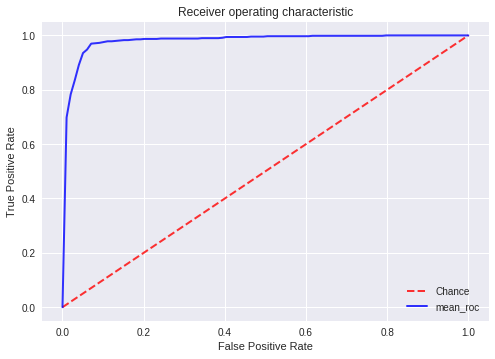

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)

tprs=[]
mean_fpr = np.linspace(0, 1, 100)
for i in roctemp2:
  tprs.append(np.interp(mean_fpr,i[0],i[1]))
  tprs[-1][0] = 0.0
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

plt.plot(mean_fpr, mean_tpr, color='b',label='mean_roc',lw=2, alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_mfcc=np.reshape(train_mfcc,(-1,train_mfcc.shape[1]*44))

In [ ]:
cls_f = {0:'from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as x',1:'from sklearn.svm import LinearSVC as x',2:'from sklearn.ensemble import ExtraTreesClassifier as x',3:'from sklearn.svm import SVC as x',4:'from sklearn.linear_model import SGDClassifier as x',5:'from sklearn.neighbors import KNeighborsClassifier as x',
       6:'from sklearn.gaussian_process import GaussianProcessClassifier as x',7:'from sklearn.naive_bayes import GaussianNB as x',8:'from sklearn.naive_bayes import BernoulliNB as x',9:'from sklearn.naive_bayes import MultinomialNB as x',
       10:'from sklearn.naive_bayes import ComplementNB as x',11:'from sklearn.tree import DecisionTreeClassifier as x',12:'from sklearn.ensemble import RandomForestClassifier as x',
       13:'from sklearn.ensemble import AdaBoostClassifier as x',14:'from sklearn.ensemble import GradientBoostingClassifier as x'}# bagging alag se h
cls_n = {0:'lda',1:'svm_linear',2:'extra tree classifier',3:'svm',4:'sgd',5:'knn',6:'gaussianprocessclf',7:'gaussian_nb',8:'bernoulli_nb',
         9:'multinomial_nb',10:'complement_nb',11:'decisiontree',12:'randomforest',13:'adaboost',14:'gradientclf'}

In [ ]:
X=train_mfcc
y=label
for i in range(0,9):
  exec(cls_f[i])
  model=x()
  
  sc_arr=[]
  for train1, test1 in cv.split(X,y):
    train,val=X[train1], X[test1]
    ytrain = y[train1]
    yval= y[test1]
    ytest = yval
    test = val
    model.fit(train, ytrain)
    score=model.score(test,ytest)
    #print(cls_n[i]," : ",score)
    sc_arr.append(score)
  print(cls_n[i],np.mean(sc_arr))

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda 0.8498902671388888


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
train_mfcc=np.reshape(train_mfcc,(-1,train_mfcc.shape[1]*train_mfcc.shape[2]))
roctemp3=[]
f1s2=[]
aps2=[]
accs2=[]
aucs2=[]
X=train_mfcc
y=label
count=0

In [ ]:

 

  
model = Sequential()
model.add(Dense(2048, activation='relu', input_shape=(train_mfcc.shape[1],)))
model_reg.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model_reg.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels_one_hot, batch_size=256, epochs=20, verbose=1, validation_data=(test_data, test_labels_one_hot))



In [ ]:
print("feature.chroma_stft",librosa.feature.chroma_stft(audio,sr=22500).shape)
print("feature.chroma_cqt",librosa.feature.chroma_cqt(audio,sr=22500).shape)
print("feature.chroma_cens",librosa.feature.chroma_cens(audio,sr=22500).shape)
print("feature.melspectrogram",librosa.feature.melspectrogram(audio,sr=22500).shape)

print("feature.mfcc",librosa.feature.mfcc(audio,sr=22500).shape)
print("feature.rms",librosa.feature.rms(audio).shape)
print("feature.rmse",librosa.feature.rmse(audio).shape)
print("feature.spectral_centroid",librosa.feature.spectral_centroid(audio,sr=22500).shape)

print("feature.spectral_bandwidth",librosa.feature.spectral_bandwidth(audio,sr=22500).shape)
print("feature.spectral_contrast",librosa.feature.spectral_contrast(audio,sr=22500).shape)
print("feature.spectral_flatness",librosa.feature.spectral_flatness(audio).shape)
print("feature.spectral_rolloff",librosa.feature.spectral_rolloff(audio,sr=22500).shape)

print("feature.poly_features",librosa.feature.poly_features(audio,sr=22500).shape)
print("feature.tonnetz",librosa.feature.tonnetz(audio,sr=22500).shape)
print("feature.zero_crossing_rate",librosa.feature.zero_crossing_rate(audio).shape)

                 


feature.chroma_stft (12, 44)
feature.chroma_cqt (12, 44)
feature.chroma_cens (12, 44)
feature.melspectrogram (128, 44)
feature.mfcc (20, 44)
feature.rms (1, 44)
feature.rmse (1, 44)
feature.spectral_centroid (1, 44)
feature.spectral_bandwidth (1, 44)
feature.spectral_contrast (7, 44)
feature.spectral_flatness (1, 44)
feature.spectral_rolloff (1, 44)
feature.poly_features (2, 44)
feature.tonnetz (6, 44)
feature.zero_crossing_rate (1, 44)


In [ ]:
!pip install scikits.talkbox

    100% |████████████████████████████████| 153kB 7.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/40/06/3f/05c8ab2b4a0cfb32ad02c449e5c949c592cd0c6458db0e7f5f
Successfully built scikits.talkbox


In [ ]:
!pip install tools

    100% |████████████████████████████████| 92kB 7.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/87/67/9b/1ca7dcb0b9ebfdc23a00c85a0644abb6fb14f9159a0df8e067
  Stored in directory: /root/.cache/pip/wheels/d6/f9/dc/4f07d8ee40d9cfca9973b3f4aeff99d0bb69900e5f3dffbf32
Successfully built tools pytils


In [ ]:
from scikits.talkbox import lpc
order=44
lpc(audio,order).shape

In [ ]:
!pip install baseZhang

    100% |████████████████████████████████| 2.6MB 11.0MB/s 
    100% |████████████████████████████████| 153kB 25.8MB/s 
    100% |████████████████████████████████| 11.8MB 3.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/c3/e3/48/2723a875e400c992e7f822cb1e6b1fd0ab7d8d22018a31ff39
  Stored in directory: /root/.cache/pip/wheels/9a/a4/ee/917f0de81626b684fd2139ef5df47744c35ebeacc9e950487b
  Failed building wheel for PyAudio
  Running setup.py clean for PyAudio
  Stored in directory: /root/.cache/pip/wheels/e9/be/bd/9953d15f2e762c0592d9c3e2894ac717570aaff7f088654dba
Successfully built baseZhang hmmlearn pyPdf
Failed to build PyAudio
yellowbrick 0.9.1 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.18.1 which is incompatible.
imbalanced-learn 0.4.3 has requirement scikit-learn>=0.20, but you'll have scikit-learn 0.18.1 which is incompatible.
fancyimpute 0.4.2 has requirement scikit-learn>=0.19.1, but you'll have scikit-learn 0.18.1 which is incompatible.
  Found exis

In [ ]:
!pip install --upgrade setuptools



    100% |████████████████████████████████| 583kB 24.2MB/s 
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 40.9.0
    Uninstalling setuptools-40.9.0:
      Successfully uninstalled setuptools-40.9.0


In [ ]:
!pip install pyaudio

  Using cached https://files.pythonhosted.org/packages/ab/42/b4f04721c5c5bfc196ce156b3c768998ef8c0ae3654ed29ea5020c749a6b/PyAudio-0.2.11.tar.gz
  Failed building wheel for pyaudio
  Running setup.py clean for pyaudio
Failed to build pyaudio
  Running setup.py install for pyaudio ... error
Command "/usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-ikph6kne/pyaudio/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /tmp/pip-record-bg8snuv1/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /tmp/pip-install-ikph6kne/pyaudio/
